In [24]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
tf.random.set_seed(26021997)

# Load data

In [3]:
dialect_df = pd.read_csv('data/clean_dataset.csv')
train_df = pd.read_csv('data/train_dataset.csv')
test_df = pd.read_csv('data/test_dataset.csv')

In [4]:
dialect_df

,id,dialect,tweet
0,1175358310087892992,IQ,لكن بالنهايه ينتفض يغير
1,1175416117793349632,IQ,يعني هذا محسوب علي البشر حيونه ووحشيه وتطلبون ...
2,1175450108898565888,IQ,مبين من كلامه خليجي
3,1175471073770573824,IQ,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,IQ,وين هل الغيبه اخ محمد
...,...,...,...
458191,1019484980282580992,BH,مبسوطين منك اللي باسطانا
458192,1021083283709407232,BH,والله ماينده ابش يختي
458193,1017477537889431552,BH,شو عملنا لك حنا تهربي مننا احنا مساكين ليش بتع...
458194,1022430374696239232,BH,الله يبارك فيها وبالعافيه


# Use keras Tokenizer to represent text

In [5]:
n_vocab = 50000
tokenizer = Tokenizer(num_words=n_vocab, lower=False)
tokenizer.fit_on_texts(dialect_df['tweet'])

In [6]:
train_tokenized = tokenizer.texts_to_sequences(train_df['tweet'])
test_tokenized = tokenizer.texts_to_sequences(test_df['tweet'])

# Tweets padding

In [7]:
max_length = 20 # pad tweets to 20 words only
X_train = pad_sequences(train_tokenized, maxlen=max_length, padding='post')
X_test = pad_sequences(test_tokenized, maxlen=max_length, padding='post')

In [8]:
encoder = LabelEncoder()
encoder.fit(train_df['dialect'])

LabelEncoder()

In [9]:
y_train = encoder.transform(train_df['dialect'])
y_test = encoder.transform(test_df['dialect'])

# Add class weight to deal with class imbalance

In [10]:
y_df = pd.DataFrame(y_train, columns=['label'])
class_weight = (1/y_df.label.value_counts()).to_dict()

# Model architecture

In [11]:
def bi_lstm():
    sequence_input = Input(shape=(max_length,), dtype='int32')
    embedding_layer = Embedding(output_dim=100, input_dim=n_vocab, mask_zero=True)
    embedding_seq = embedding_layer(sequence_input)
    dropout = Dropout(0.5)(embedding_seq)
    bi_lstm = Bidirectional(LSTM(32))(dropout)
    output = Dense(18, activation='softmax')(bi_lstm)
    return Model(sequence_input, output)

In [12]:
model = bi_lstm()
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 100)           5000000   
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 18)                1170      
                                                                 
Total params: 5,035,218
Trainable params: 5,035,218
Non-trainable params: 0
___________________________________________________

# Model training

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=1024, class_weight=class_weight, callbacks=[early_stopping])

Epoch 1/100
399/399 [==============================] - 20s 31ms/step - loss: 1.2731e-04 - accuracy: 0.0725 - val_loss: 2.8801 - val_accuracy: 0.1166
Epoch 2/100
399/399 [==============================] - 9s 24ms/step - loss: 1.2639e-04 - accuracy: 0.1251 - val_loss: 2.8031 - val_accuracy: 0.1378
Epoch 3/100
399/399 [==============================] - 9s 24ms/step - loss: 1.1787e-04 - accuracy: 0.1810 - val_loss: 2.4703 - val_accuracy: 0.2218
Epoch 4/100
399/399 [==============================] - 10s 24ms/step - loss: 1.0625e-04 - accuracy: 0.2323 - val_loss: 2.2657 - val_accuracy: 0.2659
Epoch 5/100
399/399 [==============================] - 9s 23ms/step - loss: 9.9077e-05 - accuracy: 0.2746 - val_loss: 2.1478 - val_accuracy: 0.3041
Epoch 6/100
399/399 [==============================] - 9s 23ms/step - loss: 9.3670e-05 - accuracy: 0.3127 - val_loss: 2.0594 - val_accuracy: 0.3386
Epoch 7/100
399/399 [==============================] - 10s 24ms/step - loss: 8.9287e-05 - accuracy: 0.3448 - v

<AxesSubplot:>

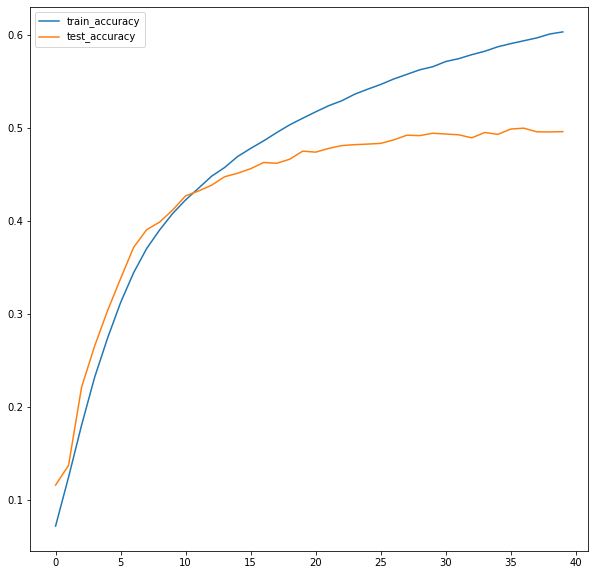

In [14]:
acc_dict = dict()
acc_dict['train_accuracy'] = history.history['accuracy']
acc_dict['test_accuracy'] = history.history['val_accuracy']
pd.DataFrame(acc_dict).plot(figsize=(10, 10))

# Train data report

In [15]:
y_train_pred = np.argmax(model.predict(X_train),axis=1)

In [16]:
y_train_pred_i = encoder.inverse_transform(y_train_pred)
y_train_i = encoder.inverse_transform(y_train)

In [17]:
train_report = classification_report(y_train_i, y_train_pred_i, output_dict=True)

In [18]:
pd.DataFrame(train_report).T

,precision,recall,f1-score,support
AE,0.552599,0.518654,0.535089,23426.000000
BH,0.515774,0.481621,0.498112,23423.000000
DZ,0.679692,0.748006,0.712215,14417.000000
EG,0.837922,0.809625,0.823531,51346.000000
IQ,0.621425,0.804216,0.701102,13806.000000
JO,0.489858,0.493206,0.491526,24874.000000
KW,0.686042,0.528256,0.596898,37514.000000
LB,0.777253,0.688859,0.730391,24603.000000
LY,0.821414,0.722690,0.768896,32516.000000
MA,0.729092,0.814981,0.769648,10280.000000


# Test data report

In [19]:
y_test_pred = np.argmax(model.predict(X_test),axis=1)

In [20]:
y_test_pred_i = encoder.inverse_transform(y_test_pred)
y_test_i = encoder.inverse_transform(y_test)

In [21]:
test_report = classification_report(y_test_i, y_test_pred_i, output_dict=True)

In [22]:
pd.DataFrame(test_report).T

,precision,recall,f1-score,support
AE,0.387260,0.372822,0.379904,2870.00000
BH,0.342195,0.314047,0.327517,2869.00000
DZ,0.478873,0.539071,0.507192,1766.00000
EG,0.777685,0.743561,0.760241,6290.00000
IQ,0.457461,0.607333,0.521850,1691.00000
JO,0.357395,0.365606,0.361454,3047.00000
KW,0.564723,0.421545,0.482741,4595.00000
LB,0.659558,0.574652,0.614184,3014.00000
LY,0.705287,0.612855,0.655830,3983.00000
MA,0.559945,0.641779,0.598075,1259.00000


# Save model

In [23]:
model.save('models/deep_learning.h5')

In [25]:
pickle.dump(tokenizer, open('models/tokenizer.sav', 'wb'))

In [26]:
pickle.dump(encoder, open('models/encoder.sav', 'wb'))